# Exploring Dandiset 001375: Septum GABA Disruption with DREADDs

> **Note**: This notebook was generated with AI assistance. Please carefully validate all code and interpretations.

## Overview
This notebook introduces [Dandiset 001375](https://dandiarchive.org/dandiset/001375/0.250406.1855), which contains electrophysiological recordings investigating the effects of septal GABAergic disruption on hippocampal and neocortical activity in mice.

### Contents
- Basic dataset structure and metadata
- Accessing raw electrophysiology signals
- Exploring neural units and spike patterns
- Trial-aligned neural activity
- Examples for further analysis

### Required Packages
```python
dandi
h5py
matplotlib
numpy
pandas
pynwb
remfile
```

## Loading the Dataset

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Initialize DANDI API client
client = DandiAPIClient()
dandiset = client.get_dandiset("001375", "0.250406.1855")

# List all NWB assets in the Dandiset
assets = list(dandiset.get_assets_by_glob("*.nwb"))

print(f"Number of NWB files: {len(assets)}\n")
for asset in assets:
    sz = asset.size / (1024 ** 3)
    print(f"- {asset.path} ({sz:.2f} GB)")

Number of NWB files: 3

- sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb (51.20 GB)
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb (64.68 GB)
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb (65.00 GB)


The Dandiset contains three large NWB files, each containing ephys recordings from different sessions or subjects.

## Accessing an Example NWB File

In [2]:
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Access remote NWB file (streaming)
asset = next(dandiset.get_assets_by_glob("sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb"))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Extract basic session and subject info
info = {
    "Session description": nwb.session_description,
    "Session start time": str(nwb.session_start_time),
    "Subject ID": nwb.subject.subject_id,
    "Subject sex": nwb.subject.sex,
    "Subject species": nwb.subject.species,
    "Subject age": nwb.subject.age,
    "Subject description": nwb.subject.description,
}

# Get counts
n_electrodes = nwb.electrodes.to_dataframe().shape[0]
n_units = nwb.units.to_dataframe().shape[0]
n_trials = nwb.trials.to_dataframe().shape[0]

info["Number of electrodes"] = n_electrodes
info["Number of units"] = n_units
info["Number of trials"] = n_trials

print("Session and Subject Info:")
for k, v in info.items():
    print(f"{k}: {v}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session and Subject Info:
Session description: mouse running laps in virtual hallway
Session start time: 2024-07-25 19:00:00-07:00
Subject ID: MS13B
Subject sex: M
Subject species: Mus musculus
Subject age: P90D
Subject description: medial septum DREADD to suppress GABA interneurons
Number of electrodes: 256
Number of units: 33
Number of trials: 387


## Exploring Neural Activity

### Raw Voltage Traces
First, let's examine raw voltage traces from the first second of recording:

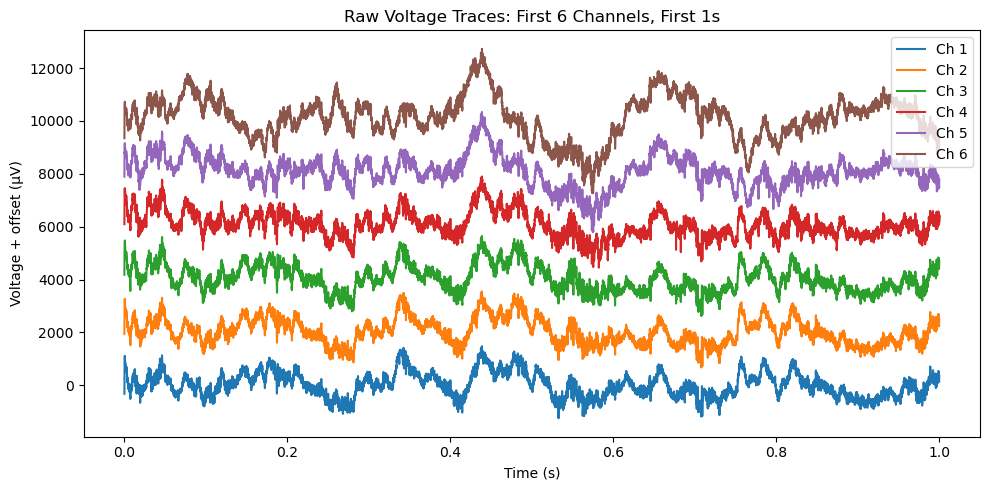

In [3]:
# Access the time_series -- raw voltage acquisition
ts = nwb.acquisition['time_series']

# Extract a short segment: first 1000 ms (30,000 samples @ 30 kHz), first 6 channels
segment = ts.data[:30000, :6]  # [time, channels]
time = np.arange(segment.shape[0]) / ts.rate  # time in seconds

# Plot raw traces
plt.figure(figsize=(10,5))
for ch in range(6):
    plt.plot(time, segment[:, ch] + ch*2000, label=f'Ch {ch+1}')  # offset for visibility
plt.xlabel('Time (s)')
plt.ylabel('Voltage + offset (μV)')
plt.title('Raw Voltage Traces: First 6 Channels, First 1s')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Spike Activity Across Units

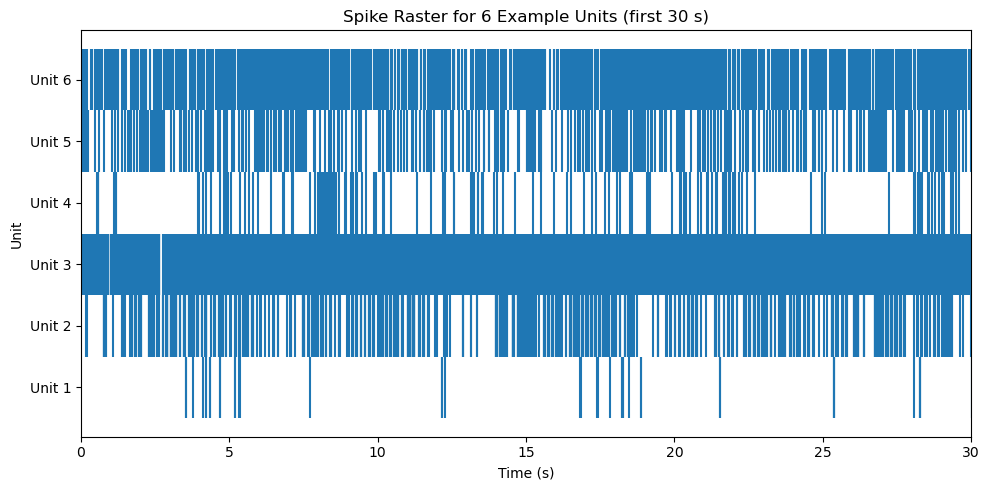

In [4]:
# Get units dataframe
units_df = nwb.units.to_dataframe()

# Plot spike rasters for first 6 units
plt.figure(figsize=(10,5))
for idx, (unit_id, row) in enumerate(units_df.head(6).iterrows()):
    spike_times = row['spike_times']
    plt.vlines(spike_times, idx+0.5, idx+1.5)
plt.yticks(np.arange(1, 7), [f'Unit {uid}' for uid in units_df.head(6).index])
plt.xlabel('Time (s)')
plt.ylabel('Unit')
plt.title('Spike Raster for 6 Example Units (first 30 s)')
plt.xlim(0, 30)
plt.tight_layout()
plt.show()

### Trial-Aligned Neural Activity
We can align spike times to behavioral events (trial starts) to investigate neural responses:

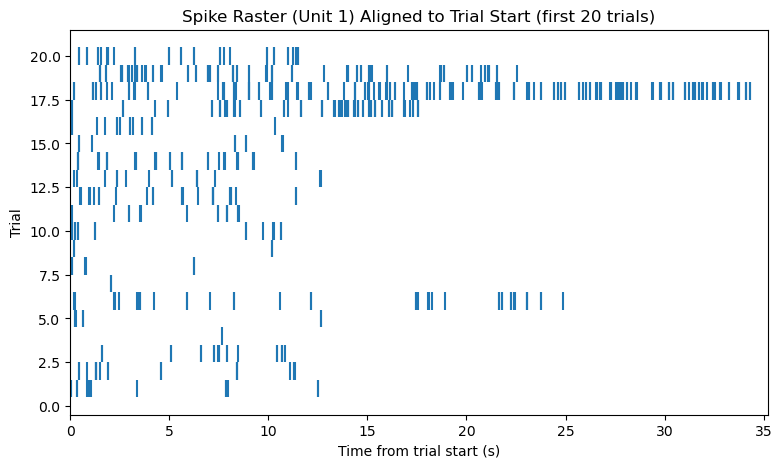

In [5]:
# Get trials dataframe
trials_df = nwb.trials.to_dataframe()

# Select example unit (first unit)
unit_id, unit_row = next(units_df.iterrows())
spike_times = np.array(unit_row['spike_times'])

# Use first 20 trials
trial_starts = trials_df['start_time'].values[:20]
trial_durations = (trials_df['stop_time'] - trials_df['start_time']).values[:20]

# Align spikes to trial start
peri_spike_times = []
for t_start, t_dur in zip(trial_starts, trial_durations):
    rel_spikes = spike_times[(spike_times >= t_start) & (spike_times <= t_start+t_dur)] - t_start
    peri_spike_times.append(rel_spikes)

# Plot trial-aligned raster
plt.figure(figsize=(9, 5))
for i, spikes in enumerate(peri_spike_times):
    plt.vlines(spikes, i+0.5, i+1.5)
plt.xlabel('Time from trial start (s)')
plt.ylabel('Trial')
plt.title(f'Spike Raster (Unit {unit_id}) Aligned to Trial Start (first 20 trials)')
plt.xlim(0, np.max(trial_durations))
plt.show()

## Summary & Next Steps

This notebook has demonstrated:
- How to access and load NWB files from this Dandiset
- Basic data structures and content (electrodes, units, trials)
- Methods to visualize raw signals and spike patterns
- Trial-based analysis approaches

### Suggested Analyses
- Examine field potentials and their relationship to spiking
- Investigate unit cross-correlations
- Compare activity patterns across behavioral states
- Study effects of DREADD manipulation on neural dynamics

### Code Reuse
The code shown here can be adapted for any of the three NWB files in the Dandiset by modifying the asset path. All files follow the same basic structure demonstrated here.